In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 50


# Importing Datasets

In [3]:
#airlines = pd.read_csv("C:\\Users\KA089588\OneDrive - Cerner Corporation\Desktop\FLYR\airlines.csv")
#airports = pd.read_csv("C:\\Users\KA089588\OneDrive - Cerner Corporation\Desktop\FLYR\airports.csv")
flights = pd.read_csv("C:\\Users\KA089588\OneDrive - Cerner Corporation\Desktop\FLYR\airports.csv")

OSError: [Errno 22] Invalid argument: 'C:\\Users\\KA089588\\OneDrive - Cerner Corporation\\Desktop\\FLYR\x07irports.csv'

In [5]:
flights.info()

NameError: name 'flights' is not defined

In [16]:
flights.head()

NameError: name 'flights' is not defined

# DATA CLEANING

**Reduce down the dataset to March**

In [6]:
flights = flights[flights['MONTH'] == 1]

NameError: name 'flights' is not defined

In [7]:
flights.shape

NameError: name 'flights' is not defined

In [8]:
import datetime,warnings

In [9]:
flights['DATE'] = pd.to_datetime(flights[['YEAR','MONTH', 'DAY']])

NameError: name 'flights' is not defined

**Merge the take-off hour with the flight date**

In [10]:
def format_hour(chain):
    if pd.isnull(chain):
        return np.nan
    else:
        if chain == 2400: chain = 0
        chain = "{0:04d}".format(int(chain))
        hour = datetime.time(int(chain[0:2]), int(chain[2:4]))
        return hour

Combine two columns of the dataframe to create a datetime format

In [10]:
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [17]:
def create_flight_time(df, col):    
    list = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            list.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            list.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            list.append(combine_date_hour(cols))
    return pd.Series(list)

In [18]:
flights['SCHEDULED_DEPARTURE'] = create_flight_time(flights, 'SCHEDULED_DEPARTURE')
flights['DEPARTURE_TIME'] = flights['DEPARTURE_TIME'].apply(format_hour)
flights['SCHEDULED_ARRIVAL'] = flights['SCHEDULED_ARRIVAL'].apply(format_hour)
flights['ARRIVAL_TIME'] = flights['ARRIVAL_TIME'].apply(format_hour)
#__________________________________________________________________________
flights.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

NameError: name 'flights' is not defined

In [11]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
flights.drop(variables_to_remove, axis = 1, inplace = True)
flights = flights[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
flights[:5]

NameError: name 'flights' is not defined

In [12]:
missing_flights = flights.isnull().sum(axis=0).reset_index()
missing_flights.columns = ['variable', 'missing values']
missing_flights['filling factor (%)']=(flights.shape[0]-missing_flights['missing values'])/flights.shape[0]*100
missing_flights.sort_values('filling factor (%)').reset_index(drop = True)

NameError: name 'flights' is not defined

In [15]:
flights.dropna(inplace = True)

In [14]:
flights.head()

NameError: name 'flights' is not defined

In [13]:
flights.shape

NameError: name 'flights' is not defined

In [18]:
print("No. of airports: {}".format(len(flights['ORIGIN_AIRPORT'].unique())))

No. of airports: 312


In [19]:
airports

NameError: name 'airports' is not defined

In [20]:
airlines

NameError: name 'airlines' is not defined

In [21]:
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [22]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
             'mean': group.mean()}

In [21]:
global_stats = flights['DEPARTURE_DELAY'].groupby(flights['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('mean')
global_stats


NameError: name 'flights' is not defined

In [22]:

origin_nb = dict()
for carrier in abbr_companies.keys():
    list_origin_airport = flights[flights['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(list_origin_airport)



NameError: name 'abbr_companies' is not defined

In [23]:
import matplotlib.pyplot as plt 
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of destiantion airports', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

TypeError: no numeric data to plot

In [24]:
identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

NameError: name 'airports' is not defined

MEAN DELAY PER ARIPORT

In [25]:
airport_mean_delays = pd.DataFrame(pd.Series(flights['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    flights1 = flights[flights['AIRLINE'] == carrier]
    test = flights1['DEPARTURE_DELAY'].groupby(flights['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean']

NameError: name 'flights' is not defined

NameError: name 'airport_mean_delays' is not defined

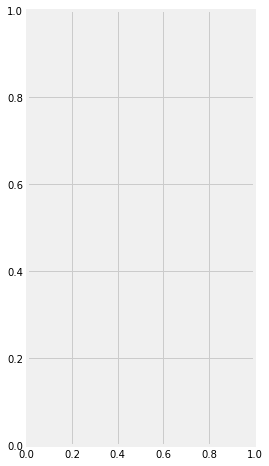

In [26]:
import seaborn as sns
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()


average delay on the various paths A → B, as well as the standard deviation

In [27]:
import scipy
from scipy.optimize import curve_fit
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, list_retards in list_trajet:
    #_____________________________________________
    # set the labels as the airport from origin
    index = route.split('-')[0]
    x_label.append(identify_airport[index])
    #______________________________________________________________________________
    # put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in list_retards]
    #________________________________________
    # compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(10,4))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = [std_min, std_val], fmt='o') 
ax.set_title('Mean route delays for "{}"'.format(abbr_companies[carrier]),
             fontsize=14, weight = 'bold')
plt.ylabel('Mean delay at origin (minutes)', fontsize=14, weight = 'bold', labelpad=12)
#___________________________________________________
# define the x,y range and positions of the ticks
imin, imax = 145, 230
plt.xlim(imin, imax) ; plt.ylim(-20, 45)
list_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    list_ticks.append(j)
#_____________________________
# and set the tick parameters  
ax.set_xticks(list_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)

plt.show()

NameError: name 'list_trajet' is not defined

The error bars associated with the different paths correspond to the standard deviations. In this example, it can be seen that for a given airport of origin, delays will fluctuate depending on the destination. We see, for example, that here the greatest variations are obtained for New York or Miami where the initial average delays vary between 0 and ∼ 20 minutes.

# DATA MODELLING

In [31]:
df_train = flights[flights['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = flights[flights['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
flights = df_train

In [28]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = flights[(flights['AIRLINE'] == carrier) & (flights['ORIGIN_AIRPORT'] == id_airport)]
    
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    
    # Conversion: date + hour -> hour
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['hour_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    
    # grouping of flights by departure time and averaging
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['hour_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    
    
    # hour to second conversion
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['hour_depart_min'] = test2['hour_depart'].apply(fct)
    return test2


In [33]:
def get_merged_delays(flights, carrier):
    list_airports = flights[flights['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    i = 0
    list_columns = ['AIRPORT_ID', 'hour_depart_min', 'mean']
    for id_airport in list_airports:
        test2 = get_flight_delays(flights, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT_ID'] = id_airport
        test2 = test2[list_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df


In [34]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
carrier = 'AA'
merged_df = get_merged_delays(flights, carrier)
merged_df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/u

(1831, 3)

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT_ID'])

# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT_ID'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

In [29]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['hour_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)


NameError: name 'integer_encoded' is not defined

# LINEAR REGRESSION

The matrices X and Y thus created can be used to perform a linear regression:

In [30]:
from sklearn import metrics, linear_model #modelling
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = pd.DataFrame(lm.predict(X))
print(predictions.head(50))
print("MSE =", metrics.mean_squared_error(predictions, Y))

NameError: name 'X' is not defined

number of predictions where the differences with real values is greater than 15 minutes

In [31]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)


NameError: name 'Y' is not defined

# POLYNOMIAL REGRESSION

In [61]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
result = pd.DataFrame(regr.predict(X_))
print(result.head(50))
print("MSE =", metrics.mean_squared_error(result, Y))

NameError: name 'regr' is not defined

We can see that a polynomial fit improves slightly the MSE score. In practice, the percentage of values where the difference between predictions and real delays is greater than 15 minutes is:

In [41]:


icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)



'4.81%'



Two models were fit and tested on the training set.

SETTING THE FREE PARAMETERS


In [42]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [33]:


X_train.shape



NameError: name 'X_train' is not defined

In [34]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = pd.DataFrame(regr.predict(X_))
print(result.head(50))
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)


NameError: name 'X_train' is not defined

TESTING THE TEST SET

In [36]:
X_ = poly.fit_transform(X_test)
result = pd.DataFrame(regr.predict(X_))
print(result.head(50))
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)


NameError: name 'X_test' is not defined

Here, we see that the fit is particularly bad with a MSE > 500, which means that the fit performs poorly when generalyzing to other data. Now let's examine in detail the reasons why we have such a bad score. Below, I examing all the terms of the MSE calculation and identify the largest terms:

In [35]:
sum = 0
for values in zip(result, Y_test):
    add = (float(values[0]) - float(values[1]))**2
    sum += add
    if add > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(add, float(values[0]), float(values[1])))

NameError: name 'result' is not defined

We see that some predictions show very large errors. In practice, this can be explained by the fact that during the separation in train and test sets, data with no equivalent in the training set was put in the test data.

In [67]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [68]:
X_ = poly.fit_transform(X_test)
result = pd.DataFrame(ridgereg.predict(X_))
print(result.head(50))
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

           0
0  -1.573715
1  -1.559381
2  -1.530468
3  -1.486481
4  -1.396289
5  -1.380970
6  -0.391916
7  -0.371913
8  -0.351827
9  -0.331659
10 -0.311408
11 -0.270661
12 -0.250164
13 -0.229585
14 -0.146448
15 -0.125458
16 -0.104386
17 -0.095934
18 -0.040676
19 -0.019276
20  0.006514
21  0.023773
22  0.132831
23  0.154889
24  0.177029
25  0.221557
26  0.243944
27  0.288964
28  0.334313
29  0.425997
30  0.449124
31  0.495624
32  0.518997
33  0.565989
34  0.660961
35  0.781524
36  0.830325
37  0.854848
38  0.879454
39  1.028814
40  1.079258
41  1.130031
42  1.155541
43  1.181133
44  1.232563
45  1.258401
46  1.284322
47  1.310325
48  1.415158
49  1.441571
Mean squared error =  53.908147858359904


In [37]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10, normalize=True)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

NameError: name 'Ridge' is not defined

In [70]:
ridgereg = Ridge(alpha = parameters[0], normalize=True)
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

52.217818271961136


# TESTING

In [38]:
carrier = 'WN'
merged_df_test = get_merged_delays(df_test, carrier)


NameError: name 'get_merged_delays' is not defined

In [39]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT_ID'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT_ID'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['hour_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

NameError: name 'label_airports' is not defined

In [40]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

NameError: name 'X_test' is not defined